# **CIS 5300 Fall 2022 - Homework 3 - Sentiment Analysis with Deep Neural Networks**

In this assignmet you will use Pytorch, a popular deep learning library, to create sentiment classifiers using some of the models we have talked about in class. The goal of the assignment is to familiarize yourself with Pytorch, and a few of the issues specific to text processing using neural networks on GPUs. We will use Sentiment Analysis as an example classification problem, and consider a simple binary version of the problem. You will need to implement classifiers using Deep Averaging Networks and different Recurrent Neural Networks (i.e. LSTMs). Finally, you will need to make a thorough comparison of these approaches, and do a qualitative analysis of the errors.

This assignment consists of two parts. Completing the coding section will help you to complete the report:

1.   (75 points) A coding portion within this notebook, with test cases evaluated through PennGrader.
2.   (75 points) A written report asking you to evaluate and analyze variants of the systems you design. Please answer all questions within the the following template: https://www.overleaf.com/read/sjtwwtnptzzx

Please read the written report requirements before you start the coding portion.

In the past, we introduced a version of this assignment for 5190. You will be asked to go much further here but if you are familiar with parts of this assignment from that class, you may reuse code.



## Setup 1. PennGrader Setup

In [1]:
## DO NOT CHANGE ANYTHING, JUST RUN
# %%capture
!pip install penngrader-client dill

In [2]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Overwriting notebook-config.yaml


In [3]:
!cat notebook-config.yaml


grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'


In [4]:
from penngrader.grader import *

## TODO - Start
STUDENT_ID = 56923113 # YOUR PENN-ID GOES HERE AS AN INTEGER#
## TODO - End

SECRET = STUDENT_ID
grader = PennGrader('notebook-config.yaml', 'cis5300_fall_2023_HW3', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 56923113

Make sure this correct or we will not be able to store your grade


In [5]:
def reload_grader():
    grader = PennGrader('notebook-config.yaml', 'cis5300_fall_2023_HW1', STUDENT_ID, SECRET)
    return grader

In [6]:
# check if the PennGrader is set up correctly
# do not change this cell, see if you get 1/1!
name_str = 'Yu Feng'
grader.grade(test_case_id = 'name_test', answer = name_str)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Setup 2: Dataset/Packages

Importing packages

In [7]:
#@title
from __future__ import division
import os, sys, re, json, time, datetime, shutil
import itertools, collections
from importlib import reload

import random
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
np.random.seed(42)  # don't change this line

import base64

# NLTK, NumPy, and Pandas.
import nltk
from nltk.tree import Tree
from numpy import random as rd
import random

import collections
import re
import time
import itertools
from collections import defaultdict, Counter

import glob
from argparse import ArgumentParser

#Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# !pip3 install wget

Downloading Required files

[train parquet file](https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/train.parquet)

[dev parquet file](https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/dev.parquet)

[test parquet file](https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/test.parquet)

[tokens in training data](https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/train_tokens.txt)

In [8]:
#@title
# !wget  -c  https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/train_tokens.txt
# !wget  -c  https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/train.parquet
# !wget  -c  https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/dev.parquet
# !wget  -c  https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/test.parquet

If the cells above fails to download all the files, rerun a couple of times or download them and add them manually.

In [9]:
train_file = "train.parquet"
dev_file = "dev.parquet"
test_file = "test.parquet"
vocab_file = "train_tokens.txt"

## 1. Introduction to Pytorch

PyTorch is an optimized tensor library for deep learning using GPUs and CPUs. This homework will be using PyTorch to build Neural Networks to solve an NLP classification problem.

If you are new to using the framework it is worthwhile to spend an hour reviewing the concepts of tensors, autograd, training classifiers etc in [this tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

Refer to [this tutorial](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html) to learn more about how to build models with Pytorch.

## 2. Stanford Sentiment Treebank(SST)

We'll be using [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/index.html) (SST) dataset, a dataset introduced by [(Socher et al. 2013)](http://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf) consisting of 11,855 sentences drawn from a corpus of movie reviews (originally from Rotten Tomatoes), each labeled with sentiment on a five-point scale.

An example of the five-point scale is:
```
sentence: [A warm , funny , engaging film .]
label:    4 (very positive)
```


**Note:** Unlike most classification datasets, SST is also a _treebank_, which means each sentence is associated with a tree structure that decomposes it into subphrases. So for the example above, we'd also have sentiment labels for `[warm , funny]` and `[engaging film .]` and so on. The tree structure will comes in handy for complex NLP tasks and we will be using it briefly to analyze an example that has negation. The data is distributed as serialized trees in [S-expression](https://en.wikipedia.org/wiki/S-expression) form, like this:
```
(4 (4 (2 A) (4 (3 (3 warm) (2 ,)) (3 funny))) (3 (2 ,) (3 (4 (4 engaging) (2 film)) (2 .))))
```
Generally, we can exploit these richer annotations when training a classifier by also using phrases as training instances. This augmented training signal is important for getting good performance for models that have many parameters.

We've downloaded the dataset and parse the S-expressions into a dataframe. Run the remaining cells in Section 2 to setup the dataset.


***In this assignment, we simplified the task from multi-class classification to binary classification. The label in the dataset would be either 0 (negative sentiment) or 1 (positive sentiment)***



### 2.1 Parsing Tree Structure

In [10]:
#@title
class SSTDataset(object):
    def __init__(self, train_file, dev_file, test_file, vocab_file, V=20000):
        self.vocab = None
        self.train = pd.read_parquet(train_file)
        self.dev = pd.read_parquet(dev_file)
        self.test = pd.read_parquet(test_file)
        train_words =[]
        with open(vocab_file) as f:
            train_words = f.readlines()
        train_words = [w.strip() for w in train_words]
        # Build vocabulary over training set
        self.vocab = Vocabulary(train_words, size=V)
        print("Train set has {:,} words".format(self.vocab.size))

    def get_filtered_split(self, split='train',is_root = True):
        df = getattr(self, split)
        if is_root:
            df = df[df.is_root]
        return df

    def as_padded_array(self, split='train', max_len=40, pad_id=0,is_root = True):
        df = self.get_filtered_split(split,is_root)
        x, ns = pad_np_array(df.ids, max_len=max_len, pad_id=pad_id)
        y = np.empty((1,1))
        if split != 'test':
            y  = np.array(df.label, dtype=np.int32)
        return x, ns, y

    def as_sparse_bow(self, split='train',is_root = True):
        from scipy import sparse
        df = self.get_filtered_split(split,is_root)
        x = id_lists_to_sparse_bow(df['ids'], self.vocab.size)
        if split != 'test':
            return x, np.array(df.label, dtype=np.int32)
        return x

    Example_fields = ["tokens", "ids", "label", "is_root", "root_id"]
    Example = collections.namedtuple("Example", Example_fields)

    def canonicalize(self, raw_tokens):
        wordset=(self.vocab.wordset if self.vocab else None)
        return canonicalize_words(raw_tokens, wordset=wordset)

# Constants for use by other modules.
START_TOKEN = u"<s>"
END_TOKEN   = u"</s>"
UNK_TOKEN   = u"<unk>"

def require_package(package_name):
    import pkgutil
    import subprocess
    import sys
    if not pkgutil.find_loader(package_name):
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package_name])

def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=True):
    word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset):
        return word
    else:
        return UNK_TOKEN

def canonicalize_words(words, **kw):
    return [canonicalize_word(word, **kw) for word in words]


def pad_np_array(example_ids, max_len=250, pad_id=0):
    arr = np.full([len(example_ids), max_len], pad_id, dtype=np.int32)
    ns = np.zeros([len(example_ids)], dtype=np.int32)
    for i, ids in enumerate(example_ids):
        cpy_len = min(len(ids), max_len)
        arr[i,:cpy_len] = ids[:cpy_len]
        ns[i] = cpy_len
    return arr, ns

def id_lists_to_sparse_bow(id_lists, vocab_size):
    from scipy import sparse
    ii = []  # row indices (example ids)
    jj = []  # column indices (token ids)
    for row_id, ids in enumerate(id_lists):
        ii.extend([row_id]*len(ids))
        jj.extend(ids)
    x = sparse.csr_matrix((np.ones_like(ii), (ii, jj)),
                          shape=[len(id_lists), vocab_size])
    return x

class Vocabulary(object):

    START_TOKEN = START_TOKEN
    END_TOKEN   = END_TOKEN
    UNK_TOKEN   = UNK_TOKEN

    def __init__(self, tokens, size=None,
                 progressbar=lambda l:l):
        self.unigram_counts = Counter()
        self.bigram_counts = defaultdict(lambda: Counter())
        prev_word = None
        for word in progressbar(tokens):  # Make a single pass through tokens
            self.unigram_counts[word] += 1
            self.bigram_counts[prev_word][word] += 1
            prev_word = word
        self.bigram_counts.default_factory = None  # make into a normal dict

        # Leave space for "<s>", "</s>", and "<unk>"
        top_counts = self.unigram_counts.most_common(None if size is None else (size - 3))
        vocab = ([self.START_TOKEN, self.END_TOKEN, self.UNK_TOKEN] +
                 [w for w,c in top_counts])

        # Assign an id to each word, by frequency
        self.id_to_word = dict(enumerate(vocab))
        self.word_to_id = {v:k for k,v in self.id_to_word.items()}
        self.size = len(self.id_to_word)
        if size is not None:
            assert(self.size <= size)

        # For convenience
        self.wordset = set(self.word_to_id.keys())

        # Store special IDs
        self.START_ID = self.word_to_id[self.START_TOKEN]
        self.END_ID = self.word_to_id[self.END_TOKEN]
        self.UNK_ID = self.word_to_id[self.UNK_TOKEN]

    def words_to_ids(self, words):
        return [self.word_to_id.get(w, self.UNK_ID) for w in words]

    def ids_to_words(self, ids):
        return [self.id_to_word[i] for i in ids]

    def ordered_words(self):
        """Return a list of words, ordered by id."""
        return self.ids_to_words(range(self.size))


### 2.2 Brief Look at SSTDataset Functionality



In [11]:
ds = SSTDataset(train_file, dev_file, test_file, vocab_file, V=20000)

Train set has 16,474 words


A few members of the `SSTDataset()` class that we will be using are:
- **`ds.vocab`**: a `vocabulary.Vocabulary` object managing the model vocabulary.
- **`ds.{train,dev,test}`**: a Pandas DataFrame containing the _processed_ examples, including all subphrases. `label` is the target label, `is_root` denotes whether this example is a root node (full sentence), and `tokens` are the tokenized words from the original sentence.

Note if you set `root_only=True` the dataframe will return only examples corresponding to whole sentences. If you set `root_only=False` the dataframe will return examples for all phrases.

In [12]:
is_root = False

## 3. [Deep Averaging Networks](https://people.cs.umass.edu/~miyyer/pubs/2015_acl_dan.pdf)

![dan](https://miro.medium.com/max/904/1*0LezMYWUk3pXptoMdO5M_Q.png)


Vector space models represent words using high dimensional vectors called embeddings.
Since sentences are made up of multiple words, each with their own embeddings, we must compose embeddings together to produce a classifier.

Composition functions can be orginized based on the properties they capture.
For example, some composition functions can completely ignoring sentence order.
Composition functions can vary in complexity, trying to capture different aspects of language that may be important.
In this assignment, we will explore two simple approaches for composing input embeddings to produce a classifier.

Deep averaging networks (DAN) are an unordered model which can perform very well on sentence level classification tasks.
While not the state-of-the-art anymore, it generally performs well, is very simple to implement and apply, and very computationally fast to execute.

The archecture for a DAN is described in the figure above.
DANs works in three simple steps:
1. Take the vector average of the embeddings
associated with an input sequence of tokens
2. Pass that average through one or more feedforward layers
3. Perform (linear) classification on the final
layer’s representation


We will walk you through the process of setting up DAN.
You will need to implement snippets along the way and we will provide PennGrader routines to help test correctness.  You will need to implement the following elements:


*   Configuring word embeddings (Sections 3.1-3.3).

*   Implementing the neural archecture in the figure above (Sections 3.4 - 3.6)

*   Training and hyper-parameter tuning the model (Section 3.7)

Validating hyper-parameters is a crucial part of making any deep network work, as the models can be very sensitive. You will need to validate hyperparameters of the archecture such as depth, choice of non-linearity or dropout, as well as learning hyper-parameters. In the report, you will need to include a table with this exploration.

At the end of section 3, you we will evalaute the qualitity of your DAN on test data. It is possible to get as high as 85\% on our test data. You will be graded on a linear scale between 83 and 85%. In our experiments, performance on the validation set and test set are comparable.

If you are getting non-zero credit on the PennGrader cell at the end, you are on the right track but may need to validate more hyper-parameters. Select reasonable hyper-parameter experiments, focusing on the parameters that you believe will have most impact on the final performance. Do not experiment randomly or in too fine-grained a way, as you risk overfitting the validation set.



### 3.1 [Glove Embeddings](https://nlp.stanford.edu/projects/glove/)
We are downloading pretrained glove word vectors that has been trained on Common Crawl data, a snapshot of the whole web.
These embeddings serve as excelent initilizations for embeddings our model needs.
Downloading glove embeddings (This will take around 10 minutes)

In [13]:
#this takes about 10 minutes to run
# !wget -nc https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip
# !unzip glove.840B.300d.zip
# !ls -lat

In [14]:
glove_file = "glove.840B.300d.txt"

In [15]:
ds

In [16]:
train_x, train_ns, train_y = ds.as_padded_array("train",is_root = is_root)
dev_x, dev_ns, dev_y = ds.as_padded_array("dev",is_root = is_root)
test_x, test_ns,_  = ds.as_padded_array("test",is_root = is_root)

print("Training set:   x = {:s} sparse, ns={:s}, y = {:s}".format(str(train_x.shape), str(train_ns.shape),
                                                str(train_y.shape)))
print("Validation set: x = {:s} sparse, ns={:s}, y = {:s}".format(str(dev_x.shape), str(dev_ns.shape),
                                                str(dev_y.shape)))
print("Test set:       x = {:s} sparse, ns={:s}".format(str(test_x.shape), str(test_ns.shape)))

Training set:   x = (98794, 40) sparse, ns=(98794,), y = (98794,)
Validation set: x = (13142, 40) sparse, ns=(13142,), y = (13142,)
Test set:       x = (26052, 40) sparse, ns=(26052,)


In [17]:
#look at the format of the file
!head glove.840B.300d.txt

, -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 -0.47215 -0.18366 -0.3

#### Get Glove embeddings
In this section we want to populate the `glove` dictionary with a mapping of word to the embedding. Remember: the embedding should be an `np.array` of type `np.float` The glove dictionary should only have words that are present in the train vocabulary.


Hint: For getting the word and corresponding embedding from the glove file, remember refer to the above structure of the word to embedding mapping.

In [18]:
#takes about 1 minute to read through the whole file and find the words we need.
def get_glove_mapping(vocab, file):
    """
    Gets the mapping of words from the vocabulary to pretrained embeddings

    INPUT:
    vocab       - set of vocabulary words
    file        - file with pretrained embeddings

    OUTPUT:
    glove_map   - mapping of words in the vocabulary to the pretrained embedding

    """

    glove_map = {}
    with open(file,'rb') as fi:
        for l in fi:
            
            try:
                #### STUDENT CODE HERE ####
                ## only include vectors that are found in the vocabulary.
                values = l.split()
                word = values[0].decode('utf-8')
                vector = np.asarray(values[1:], dtype='float32')                
                if word in vocab:
                    
                    glove_map[word] = vector
                #### STUDENT CODE ENDS HERE ####
            except:
                #some lines have urls, we don't need them.
                pass
    return glove_map

In [19]:
vocab_set = set(ds.vocab.ordered_words())
glove_map = get_glove_mapping(vocab_set,"./glove.840B.300d.txt")
glove_keys = glove_map.keys()

In [20]:
glove_keys

dict_keys([',', '.', 'the', 'and', 'to', 'of', 'a', 'in', ':', 'is', 'for', 'that', '-', 'on', 'you', 'with', "'s", 'it', 'are', 'by', 'at', 'be', 'this', 'as', 'from', 'was', 'have', 'or', '...', 'your', 'not', '!', '?', 'will', 'an', "n't", 'can', 'but', 'all', 'my', 'has', 'do', 'we', 'they', 'more', 'one', 'about', 'he', ';', "'", 'out', '$', 'their', 'so', 'his', 'up', '&', 'like', 'which', 'if', 'would', 'our', 'me', 'who', 'just', 'time', 'what', 'had', 'when', 'there', 'been', 'some', 'get', 'were', 'other', 'also', 'her', 'them', 'new', 'no', 'any', 'people', 'than', 'into', 'only', 'how', 'its', 'first', 'said', 'i', 'over', 'make', 'good', 'know', 'very', 'am', 'now', 'see', 'may', 'she', 'could', 'most', 'then', "'m", 'use', 'these', 'did', 'way', 'here', 'well', 'work', 'two', '=', 'think', 'much', 'should', 'us', 'years', 'many', 'back', 'because', '#', 'after', 'need', 'year', 'even', 'does', 'really', 'through', 'want', 'great', 'him', 'where', 'go', 'day', '--', 'such'

In [21]:
# PennGrader Grading Cell, do not modify.
# This tests you have the right number of keys, and that a few elements are in there.
grader.grade(test_case_id = 'test_glove_embedding', answer = list(glove_map.keys()))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.2 Embedding Matrix

Fill in the following constants about the system we are building.  These are required for setting up the DAN.

In [22]:
## TODO
d_out = 2  # the number of output classes of the model
n_embed = ds.vocab.size # the total number of word embeddings in the input layer
d_embed = 300 # the dimensionality of each word embedding

In [23]:
# PennGrader Grading Cell, do not modify.
# This tests you have the right number of keys, and that a few elements are in there
grader.grade(test_case_id = 'test_dimensions', answer = (d_out, n_embed, d_embed))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### Initializing the embedding matrix

Create a embedding_matrix for the parameters to be learnt. Fill in the rows of the embedding matrix with the glove embeddings. Use word id as row index.  If you do not find a particular word or you need to randomize the embeddings, initialize the embedding matrix with `np.random.normal`

Hint: `ds.vocab.ordered_words()` can give you the mapping of id to words. `glove` has the embeddings you need.

In [24]:
def get_embedding_matrix(n_embed, d_embed, glove_map, randomize_init = False):
    """
    Initialize the embedding matrix

    INPUT:
    n_embed         - size of the dictionary of embeddings
    d_embed         - the size of each embedding vector
    glove_map       - the map you created storing all of embeddings you will need from GloVE
    randomize_init  - if True, ignore the embeddings from glove_map and intilize all embeddings to random guassian noise (np.random.normal will be useful).

    OUTPUT:
    embedding_matrix  - a numpy matrix of mapping from word id to embedding

    """
    #### STUDENT CODE HERE ####
    embedding_matrix = np.zeros((n_embed, d_embed))
    
    if randomize_init:
        embedding_matrix = np.random.normal(0, 1, (n_embed, d_embed))
    else:
        for id, word in enumerate(ds.vocab.ordered_words()):
            if word in glove_map:
                embedding_matrix[id] = glove_map[word]

    #### STUDENT CODE ENDS HERE ####
    return embedding_matrix

In [25]:
n_embed

16474

In [26]:
len(glove_map)

15506

In [27]:
len(ds.vocab.ordered_words())

16474

In [28]:
embedding_matrix = get_embedding_matrix(n_embed, d_embed, glove_map)
embedding_data = (embedding_matrix.shape, embedding_matrix[0:155])

In [29]:
# PennGrader Grading Cell, do not modify.
# This sets that you have the right values in the embedding matrix.
grader.grade(test_case_id = 'test_weight_matrix', answer = embedding_data)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 3.3 Embedding Layer
The following is initilization code for an embedding module we will include in our DAN.
Use the embedding matrix to create the embedding layer by using `nn.Embedding`.

In [30]:
def create_emb_layer(embedding_matrix, non_trainable=False):
    """
    Create the embedding layer

    INPUT:
    embedding_matrix  - matrix of mapping from word id to embedding
    non_trainable   - Flag for whether the embedding matrix should be trained.
                      If it is set to True, don't update the gradients

    OUTPUT:
    emb_layer       - embedding layer

    """
    #### STUDENT CODE HERE ####
    
    num_embeddings, embedding_dim = embedding_matrix.shape

    
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)

    
    emb_layer.weight.data.copy_(torch.from_numpy(embedding_matrix))


    emb_layer.weight.requires_grad = non_trainable
    #### STUDENT CODE ENDS HERE ####

    return emb_layer

### 3.4 Defining the Dataloader

For the ease of batch processing, we are defining the following to use the functionality of the Dataloader in Pytorch.

You can read more about it in [this tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).


In [31]:
class SSTpytorchDataset(Dataset):
    def __init__(self, sst_ds, word_dropout = 0.3, split='train'):
        super(SSTpytorchDataset, self).__init__()
        assert split in ['train', 'test', 'dev'], "Error!"
        self.ds = sst_ds
        self.split = split
        self.word_dropout = word_dropout
        self.data_x, self.data_ns, self.data_y = self.ds.as_padded_array(split,is_root =is_root)
        self.mask = np.zeros_like(self.data_x)

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        y = 2
        if self.split != 'test':
            y = self.data_y[idx]

        mask = np.zeros(len(self.data_x[idx]))
        sentl = self.data_ns[idx]
        total_dropped = 0
        for j in range(0,sentl):
            mask[j] = 1
            if self.split == 'train':
                rv = random.random()
                if rv  < self.word_dropout:
                    mask[j] = 0
                    total_dropped+=1
        if total_dropped >= sentl:
            mask[0] = 1
        for i in range(sentl,len(self.data_x[idx])):
            mask[i] = 0
        self.mask[idx] = mask
        return self.data_x[idx], self.data_ns[idx], self.mask[idx], sentl, y


### 3.5 Defining DAN Architecture

#### Masking in Deep Averaging Networks

A lot of NLP applications use masking and deal with variable sequence lengths. We will need to handle this issue in our DAN. The dataloader provides enough information to do this in the form a mask indicating which elements of the batch correspond to real tokens and pad tokens.

You have to perform the following steps:

1. Change the view of the mask so it extends to the embeddings size
2. Calculate the number of words in the sequence (`den`)
3. Eliminate the tokens that aren't in the mask, and sum the rest `num`
4. return `x = num/den`

Note: You can look at [expand](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) in pytorch.

Implement this logic in the masked mean function.

#### Feedforward network

You will also need define the feedforward layers required for the final output of the classifier. We suggest you start simple, and first implement a linear classifier over the average of words embeddings. Then, introduce a feedforward neural network that operates over the average embeddings. Remeber, you must include non-linearities in your feed foward network. You will need to experiment with different depths and different non-linearities for your report.

Fill in the sections marked with following cells that handle masking and the network definition.

#### Defining the architecture for Deep Averaging Networks

In [32]:
import random as random

class DAN(nn.Module):

    def __init__(self,
                 n_embed=20000,
                 d_embed=300,
                 d_hidden=100,
                 d_out=2,
                 layer_dropout = 0.2,
                 embeddings=None,
                 depth = 2):
        super(DAN, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.embed = create_emb_layer(embedding_matrix,False)
        #### STUDENT CODE HERE ####

        ### We need to create the layers to construct the output of the classifier.
        ### One possible implementation uses the "nn.Seqential" module, which chains together multiple layers.
        
        layers = []

        # input
        layers.append(nn.Linear(d_embed, d_hidden))
        layers.append(nn.ReLU())

        # # hidden
        for _ in range(depth - 1):
            layers.append(nn.Linear(d_hidden, d_hidden))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(layer_dropout))

        # output_layer
        layers.append(nn.Linear(d_hidden, d_out))
        layers.append(nn.ReLU())

        
        
        self.feedforward_layers = nn.Sequential(*layers)
        
        
        #### STUDENT CODE ENDS HERE ####

    def masked_mean(self,v, mask):
        """
        Create the masked mean

        INPUT:
        v       - input
        mask    - mask that has 0 and 1 for all th tokens in the input
                  0 corresponds to dropping the token and 1 corresponds to keeping the token

        OUTPUT:
        x       - average

        """
        (batch, max_sent, d_embed ) = v.size()
        mask.requires_grad = False

        #### STUDENT CODE HERE ####

        #change the view of the mask so it extends to the embeddings size
        #the number surviving words
        #eliminate the tokens that aren't in the mask, and sum
        #average
        
        expanded_mask = mask.unsqueeze(-1)
        expanded_mask = expanded_mask.expand_as(v)

        # 计算序列中的有效单词数量
        den = mask.sum(dim=1, keepdim=True)  # 统计每个样本的有效单词数量

        # 将不在 mask 中的单词置零
        v_masked = v * expanded_mask

        # 对每个样本进行求和
        num = v_masked.sum(dim=1, keepdim=True)  # 求和

        # 计算平均值
        x = num / den


        #### STUDENT CODE ENDS HERE ####
        return x.mean(dim=0)

    def forward(self, text, mask):
        x = text
        
        x = self.embed(x.long())
        # print(x.shape)
        x = self.masked_mean(x,mask)
        # print(x.shape)
        x = self.feedforward_layers(x)
        # print(x.shape)
        return x


### 3.6 Training the Deep Averaging Network

The following section implements a training loop for you. Use it to train and validate your DAN. Experiment with enough hyper-parameters to pass the PennGrader test below. You should be able to get over 85 accuracy without overfitting the development set.

In [38]:
def train(model, lr = .005, drop_out = 0, word_dropout = .3, batch_size = 16, weight_decay = 1e-5, model_type= "DAN"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trainset = SSTpytorchDataset(ds, word_dropout, 'train')
    testset = SSTpytorchDataset(ds, word_dropout, 'test')
    devset = SSTpytorchDataset(ds, word_dropout, 'dev')

    train_iter = DataLoader(trainset, batch_size, shuffle=True, num_workers=0)
    test_iter = DataLoader(testset, batch_size, shuffle=False, num_workers=0)
    dev_iter = DataLoader(devset, batch_size, shuffle=False, num_workers=0)

    model = model
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay = weight_decay)


    acc, val_loss = evaluate(dev_iter, model, device, model_type)
    # return
    best_acc = acc

    print(
        'epoch |   %        |  loss  |  avg   |val loss|   acc   |  best  | time | save |')
    print(
        'val   |            |        |        | {:.4f} | {:.4f} | {:.4f} |      |      |'.format(
            val_loss, acc, best_acc))

    iterations = 0
    last_val_iter = 0
    train_loss = 0
    start = time.time()
    _save_ckp = ''
    for epoch in range(epochs):
        # train_iter.init_epoch()
        n_correct, n_total, train_loss = 0, 0, 0
        last_val_iter = 0
        for batch_idx, batch in enumerate(train_iter):
            # switch model to training mode, clear gradient accumulators
            model.train()
            optimizer.zero_grad()
            iterations += 1

            data, ns, mask, lens, label = batch

            data = data.to(device)
            label = label.to(device).long()
            mask = mask.to(device).long()
            
            # print(data.shape)
            # print(mask.shape)
            if model_type == "LSTM":
                answer = model(data, mask, lens)
            else:
                answer = model(data, mask)

            loss = criterion(answer, label)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            print('\r {:4d} | {:4d}/{} | {:.4f} | {:.4f} |'.format(
                epoch, batch_size * (batch_idx + 1), len(trainset), loss.item(),
                       train_loss / (iterations - last_val_iter)), end='')

            if iterations > 0 and iterations % dev_every == 0:
                acc, val_loss= evaluate(dev_iter, model, device, model_type)
                if acc > best_acc:
                    best_acc = acc
                    torch.save(model.state_dict(), save_path)
                    _save_ckp = '*'

                print(
                    ' {:.4f} | {:.4f} | {:.4f} | {:.2f} | {:4s} |'.format(
                        val_loss, acc, best_acc, (time.time() - start) / 60,
                        _save_ckp))

                train_loss = 0
                last_val_iter = iterations
    model.load_state_dict(torch.load(save_path)) #this will be the best model
    test_y_pred = evaluate(test_iter, model, device, model_type, "test")
    print("\nValidation Accuracy : ", evaluate(dev_iter,model, device, model_type))
    return best_acc, test_y_pred


In [41]:
def evaluate_by_work_len(loader, model, device, model_type = "DAN", split = "dev"):
    model.eval()
    n_correct, n = 0, 0
    losses = []
    y_pred = []
    acc_dict = {}
    cnt = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            data, ns, mask, lens, label = batch
            data = data.to(device)
            label = label.to(device).long()
            mask = mask.to(device).long()
            # print(data.shape, data)
            # print(mask.shape, mask)
            if model_type == "LSTM":
                answer = model(data, mask, lens)
            else:
                answer = model(data, mask)
            if split != "test":
                
                for i, length in enumerate(lens.cpu().numpy()):
                    if length not in acc_dict:
                        acc_dict[length] = {"n_correct": 0, "n_total": 0}
                        
                    acc_dict[length]["n_total"] += 1
                    
                    if torch.max(answer[i], 0)[1] == label[i]:
                        acc_dict[length]["n_correct"] += 1
                        cnt += 1

                
                n_correct += (torch.max(answer, 1)[1].view(label.size()) == label).sum().item()
                # print("cnt:", cnt, "n_cor:", n_correct)
                n += answer.shape[0]
                loss = criterion(answer, label)
                losses.append(loss.data.cpu().numpy())
            else:
                y_pred.extend(torch.max(answer, 1)[1].view(label.size()).tolist())
    print("acc_dict:",acc_dict)
    print("acc_dict.len:",len(acc_dict))
    if split != "test":
        acc = 100. * n_correct / n
        loss = np.mean(losses)
        return acc, loss, acc_dict
    else:
        return y_pred


In [62]:
def evaluate(loader, model, device, model_type = "DAN", split = "dev"):
    model.eval()
    n_correct, n = 0, 0
    losses = []
    y_pred = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            data, ns, mask, lens, label = batch
            data = data.to(device)
            label = label.to(device).long()
            mask = mask.to(device).long()
            # print(data.shape, data)
            # print(mask.shape, mask)
            if model_type == "LSTM":
                answer = model(data, mask, lens)
            else:
                answer = model(data, mask)
            if split != "test":
                n_correct += (torch.max(answer, 1)[1].view(label.size()) == label).sum().item()
                n += answer.shape[0]
                loss = criterion(answer, label)
                losses.append(loss.data.cpu().numpy())
            else:
                y_pred.extend(torch.max(answer, 1)[1].view(label.size()).tolist())
    if split != "test":
        acc = 100. * n_correct / n
        loss = np.mean(losses)
        return acc, loss
    else:
        return y_pred


The following code will train the averaging network on the training data after which it will return the accuracy achieved on the validation set as well as the predictions for the test set.

In [63]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [64]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
drop_out = 0
word_dropout = 0.1
weight_decay = 1e-5
torch.manual_seed(1234)
batch_size = 128
dev_every = 100 
epochs = 5
save_path = "best_model"
model = DAN(n_embed=n_embed, d_embed=d_embed, d_hidden=300, d_out=d_out, layer_dropout=drop_out)
dev_value, test_y_pred = train(model,lr, drop_out, word_dropout, batch_size, weight_decay, "DAN")

epoch |   %        |  loss  |  avg   |val loss|   acc   |  best  | time | save |
val   |            |        |        | 0.6930 | 55.4710 | 55.4710 |      |      |
    0 | 12800/98794 | 0.6931 | 0.6946 | 0.6931 | 56.7570 | 56.7570 | 0.01 | *    |
    0 | 25600/98794 | 0.6931 | 0.6931 | 0.6931 | 56.7570 | 56.7570 | 0.02 | *    |
    0 | 38400/98794 | 0.6931 | 0.6931 | 0.6931 | 56.7570 | 56.7570 | 0.03 | *    |
    0 | 51200/98794 | 0.6931 | 0.6931 | 0.6931 | 56.7570 | 56.7570 | 0.04 | *    |
    0 | 64000/98794 | 0.6931 | 0.6931 | 0.6931 | 56.7570 | 56.7570 | 0.05 | *    |
    0 | 76800/98794 | 0.6931 | 0.6931 | 0.6931 | 56.7570 | 56.7570 | 0.06 | *    |
    0 | 89600/98794 | 0.6931 | 0.6931 | 0.6931 | 56.7570 | 56.7570 | 0.07 | *    |
    1 | 3584/98794 | 0.6931 | 0.0243 || 0.6931 | 56.7570 | 56.7570 | 0.08 | *    |
    1 | 16384/98794 | 0.6931 | 0.6931 | 0.6931 | 56.7570 | 56.7570 | 0.09 | *    |
    1 | 29184/98794 | 0.6931 | 0.6931 | 0.6931 | 56.7570 | 56.7570 | 0.10 | *    |
    1 |

In [65]:
devset = SSTpytorchDataset(ds, word_dropout, 'dev')
dev_iter = DataLoader(devset, batch_size, shuffle=False, num_workers=0)
model_type = "DAN"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
acc, val_loss, acc_dict1 = evaluate_by_work_len(dev_iter, model, device, model_type)

acc_dict: {13: {'n_correct': 171, 'n_total': 320}, 12: {'n_correct': 198, 'n_total': 339}, 11: {'n_correct': 178, 'n_total': 354}, 10: {'n_correct': 198, 'n_total': 400}, 3: {'n_correct': 683, 'n_total': 1120}, 2: {'n_correct': 814, 'n_total': 1396}, 1: {'n_correct': 1905, 'n_total': 3043}, 7: {'n_correct': 312, 'n_total': 570}, 6: {'n_correct': 343, 'n_total': 639}, 5: {'n_correct': 455, 'n_total': 790}, 24: {'n_correct': 40, 'n_total': 76}, 23: {'n_correct': 47, 'n_total': 92}, 8: {'n_correct': 279, 'n_total': 493}, 4: {'n_correct': 504, 'n_total': 861}, 27: {'n_correct': 31, 'n_total': 68}, 26: {'n_correct': 36, 'n_total': 74}, 25: {'n_correct': 31, 'n_total': 77}, 17: {'n_correct': 88, 'n_total': 198}, 16: {'n_correct': 119, 'n_total': 225}, 30: {'n_correct': 24, 'n_total': 50}, 22: {'n_correct': 53, 'n_total': 101}, 21: {'n_correct': 67, 'n_total': 126}, 20: {'n_correct': 77, 'n_total': 142}, 19: {'n_correct': 91, 'n_total': 157}, 9: {'n_correct': 228, 'n_total': 438}, 14: {'n_cor

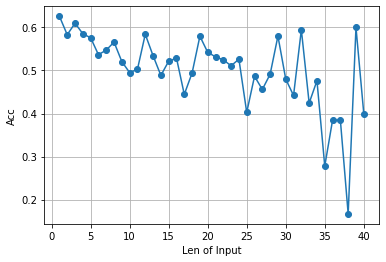

In [66]:
import matplotlib.pyplot as plt

data = acc_dict1

# 按照键对数据进行排序
sorted_data = {key: data[key] for key in sorted(data.keys())}

# 提取排序后的键和值
keys = list(sorted_data.keys())
values_n_correct = [sorted_data[key]['n_correct'] for key in keys]
values_n_total = [sorted_data[key]['n_total'] for key in keys]

# 计算 n_correct/n_total 的比例
ratios = [correct / total for correct, total in zip(values_n_correct, values_n_total)]

# 绘制折线图
plt.plot(keys, ratios, marker='o')
plt.xlabel('Len of Input')
plt.ylabel('Acc')
# plt.title('Ratio of n_correct to n_total')
plt.grid(True)
plt.show()


After you have trained your DAN, evaluate it on our hidden test set. Your score is a linear function between 83 and 85 on the test set. Experiment with different configurations on the development set until you get at least 85 on the development set. Then verify it generalizes.

---



### 3.7 Self Exploration

This is where you experiment with different configurations of training (learning rate and batch size), and the network (dropout rates, depth, hidden sizes) and report which worked best. Illustrate your expermiments with in the form of a table (learning rate vs dev accuracy and batch size vs dev accuracy). When doing this validation, it is not required to train to convergence.
You will need to report your results in the report.

In [81]:
#Do not modify this cell. This is the grading cell.
grader.grade(test_case_id = 'test_dan_predictions', answer = test_y_pred)

Correct! You earned 33/33 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 4. LSTM Networks



![LSTM](https://miro.medium.com/max/1400/1*-kBdBYzR7lpimgb3AIRkOw.png)

LSTM stands for Long Short-Term Memory Network and it is a type of Recurrent Neural Network (RNN). As you recall from the lecture, Simple RNNs can struggle with exploding or vanishing gradients and LSTMs try to improve this issue. For the next part of the coding exercise, you will implement an LSTM to solve the classification problem.

There are multiple ways to get the classification output from the hidden states of an RNN. For example, you may take the last hidden output, or you may aggregate the hidden states, use max or mean operations. Include a discussion of which method you have used in your report.

**Hint:** You might want to think about how to handle different length sentences. You can use [pack_padded_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html) and [pad_packed_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_packed_sequence.html) to achieve this.

**Note:** Bi-directional LSTMs require a concatnation of the output. Consider the PyTorch documentation carefully https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM

### 4.1 Defining the architecture for LSTM Networks

This is where you define the architecture for the LSTM Network. Ensure that you also handle the cases where you have to define a Bi-directional LSTM network. We will be reusing the data loader and training code from above, so all you need to do is complete the following class.

In [68]:
import random as random
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import LSTM, GRU

class LSTM_Classifier(nn.Module):

    def __init__(self,
                 n_embed=20000,
                 d_embed=300,
                 d_hidden=150,
                 d_out=2,
                 embeddings=None,
                 nl = 2,
                 bidirectional = True
                 ):
        super(LSTM_Classifier, self).__init__()

        self.d_hidden = d_hidden
        self.bidrectional = bidirectional
        self.num_layers = nl

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.embed = create_emb_layer(embedding_matrix,False)
        #### STUDENT CODE STARTS HERE ####
        #Define your rnn based archecture here
        self.lstm = nn.LSTM(d_embed, d_hidden, num_layers=nl, bidirectional=bidirectional)
        self.out_layer = nn.Linear(d_hidden * (2 if bidirectional else 1), d_out)
        #### STUDENT CODE ENDS HERE ####

    def forward(self, text, mask, seq_lengths):

        batch_size = text.size()[0]

        #### STUDENT CODE STARTS HERE ####
        #compute the forward pass,
        #take care to extract the apporiate parts of the rnn computation based on the length of the sentences
            # 将序列根据长度进行排序
        x = self.embed(text.long())

        sorted_seq_lengths, sort_order = seq_lengths.sort(descending=True)
        x = x[sort_order]

        # 使用 pack_padded_sequence 对输入进行填充
        packed_input = pack_padded_sequence(x, sorted_seq_lengths.cpu(), batch_first=True)

        # 将 packed_sequence 传递给 LSTM 层
        packed_output, _ = self.lstm(packed_input)

        # 使用 pad_packed_sequence 进行解填充
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # 恢复原始顺序
        _, unsort_order = sort_order.sort()
        output = output[unsort_order]

        # 提取最后一个时间步的输出作为分类结果
        if self.bidrectional:
            # 对于双向 LSTM，将前向和后向输出连接起来
            forward_output = output[:, -1, :self.d_hidden]
            backward_output = output[:, 0, self.d_hidden:]
            output = torch.cat((forward_output, backward_output), dim=1)
        else:
            output = output[:, -1, :]

        # 经过线性层进行分类
        output = self.out_layer(output)

        return output

        #### STUDENT CODE ENDS HERE ####


### 4.2 Training Loop

In [69]:
torch.manual_seed(1234)
criterion = nn.CrossEntropyLoss()
batch_size = 64
epochs = 3
dev_every = 100
lr = 0.01
save_path = "best_model"
drop_out = 0
word_dropout = 0
weight_decay = 0

model = LSTM_Classifier(n_embed=n_embed, d_embed=d_embed, d_hidden=150, d_out=d_out)
dev_value, test_y_pred = train(model, lr, drop_out, word_dropout, batch_size, weight_decay, "LSTM")

epoch |   %        |  loss  |  avg   |val loss|   acc   |  best  | time | save |
val   |            |        |        | 0.6919 | 56.7646 | 56.7646 |      |      |
    0 | 6400/98794 | 0.3325 | 0.4026 | 0.3720 | 82.4836 | 82.4836 | 0.06 | *    |
    0 | 12800/98794 | 0.2897 | 0.3126 | 0.3993 | 82.0271 | 82.4836 | 0.12 | *    |
    0 | 19200/98794 | 0.2480 | 0.2963 | 0.3424 | 84.5838 | 84.5838 | 0.19 | *    |
    0 | 25600/98794 | 0.3387 | 0.2735 | 0.3228 | 85.1164 | 85.1164 | 0.25 | *    |
    0 | 32000/98794 | 0.2374 | 0.2517 | 0.3077 | 86.3795 | 86.3795 | 0.31 | *    |
    0 | 38400/98794 | 0.2109 | 0.2400 | 0.2912 | 86.0828 | 86.3795 | 0.38 | *    |
    0 | 44800/98794 | 0.1655 | 0.2451 | 0.2801 | 87.2926 | 87.2926 | 0.44 | *    |
    0 | 51200/98794 | 0.4984 | 0.2391 | 0.2864 | 86.8665 | 87.2926 | 0.50 | *    |
    0 | 57600/98794 | 0.2079 | 0.2311 | 0.2975 | 86.2121 | 87.2926 | 0.57 | *    |
    0 | 64000/98794 | 0.2875 | 0.2271 | 0.3230 | 86.2730 | 87.2926 | 0.63 | *    |
    0 | 

In [70]:
acc, val_loss, acc_dict2 = evaluate_by_work_len(dev_iter, model, device, "LSTM")

acc_dict: {13: {'n_correct': 270, 'n_total': 320}, 12: {'n_correct': 282, 'n_total': 339}, 11: {'n_correct': 297, 'n_total': 354}, 10: {'n_correct': 343, 'n_total': 400}, 3: {'n_correct': 998, 'n_total': 1120}, 2: {'n_correct': 1264, 'n_total': 1396}, 1: {'n_correct': 2820, 'n_total': 3043}, 7: {'n_correct': 490, 'n_total': 570}, 6: {'n_correct': 540, 'n_total': 639}, 5: {'n_correct': 698, 'n_total': 790}, 24: {'n_correct': 61, 'n_total': 76}, 23: {'n_correct': 77, 'n_total': 92}, 8: {'n_correct': 409, 'n_total': 493}, 4: {'n_correct': 766, 'n_total': 861}, 27: {'n_correct': 55, 'n_total': 68}, 26: {'n_correct': 59, 'n_total': 74}, 25: {'n_correct': 60, 'n_total': 77}, 17: {'n_correct': 166, 'n_total': 198}, 16: {'n_correct': 179, 'n_total': 225}, 30: {'n_correct': 44, 'n_total': 50}, 22: {'n_correct': 91, 'n_total': 101}, 21: {'n_correct': 109, 'n_total': 126}, 20: {'n_correct': 120, 'n_total': 142}, 19: {'n_correct': 132, 'n_total': 157}, 9: {'n_correct': 369, 'n_total': 438}, 14: {'

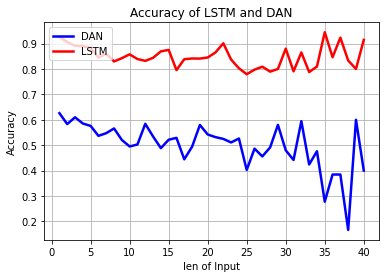

In [80]:
import matplotlib.pyplot as plt


sorted_data1 = {key: acc_dict1[key] for key in sorted(acc_dict1.keys())}
sorted_data2 = {key: acc_dict2[key] for key in sorted(acc_dict2.keys())}

# 提取排序后的键和值
keys = list(sorted_data1.keys())
values_n_correct = [sorted_data1[key]['n_correct'] for key in keys]
values_n_total = [sorted_data1[key]['n_total'] for key in keys]

# 计算 n_correct/n_total 的比例
values1 = [correct / total for correct, total in zip(values_n_correct, values_n_total)]

keys2 = list(sorted_data2.keys())
values_n_correct2 = [sorted_data2[key]['n_correct'] for key in keys2]
values_n_total2 = [sorted_data2[key]['n_total'] for key in keys2]

values2 = [correct / total for correct, total in zip(values_n_correct2, values_n_total)]


plt.plot(keys, values1, color='blue', linewidth=2.5, linestyle='-', label='DAN')
plt.plot(keys, values2, color='red', linewidth=2.5, linestyle='-', label='LSTM')

plt.legend(loc='upper left')
plt.xlabel('len of Input')
plt.ylabel('Accuracy')
plt.title('Accuracy of LSTM and DAN')
plt.grid(True)
plt.show()


### 4.3 Self Exploration

Experiment with different types of RNN networks and see which one works the best for the task (Bidirectional LSTM, GRU, Simple RNN). You have to report the difference in performance between these in your report. You should also tune the hypeparamters (learning rate and batch size, hidden dimension size) and report which worked best. Illustrate your expermiments with in the form of a table (learning rate vs dev accuracy and batch size vs dev accuracy).

After you have trained your RNN, evaluate it on our hidden test set. Your score is a linear function between 84 and 88 on the test set. Experiment with different configurations on the development set until you get at least 86 on the development set. Then verify it generalizes.

---



In [72]:
#Do not modify this cell. This is the grading cell.
grader.grade(test_case_id = 'test_rnn_predictions', answer = test_y_pred)

Correct! You earned 35/35 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 5.0 Report

At this point, you should have built at least two types of models: an order agnostic model and at least two RNN based model. You will now need to experiment with different aspects of these models and discuss the results in your report. Go to the homework template, https://www.overleaf.com/read/sjtwwtnptzzx, make a copy of the latex file, and complete all sections and questions.


## Submission:





These are the files you have to submit to gradescope

1.   Report, with all sections answered
2.   Download your jupyter notebook as a python file and submit it as "homework3.ipynb".


